In [51]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Drive mounted successfully.")
except ImportError:
    print("Not running in Google Colab - skipping drive.mount().")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted successfully.


In [52]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms

from sklearn.metrics import confusion_matrix, classification_report


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)


DATASET_ROOT = Path("/content/drive/MyDrive/Colab Notebooks/dataset")
#DATASET_ROOT = Path("/content/drive/MyDrive/Colab Notebooks/dataset_merch")
BATCH_SIZE = 8   #16,8
NUM_EPOCHS = 20   #30,20
LEARNING_RATE = 1e-3

MODEL_SAVE_PATH = f"/content/drive/MyDrive/Colab Notebooks/Group_28_CNN_FullModel.ph"

hogs_dir = DATASET_ROOT / "hogs"
no_hogs_dir = DATASET_ROOT / "no_hogs_random"
#no_hogs_dir = DATASET_ROOT / "merch_without_hogs"


print("hogs_dir:", hogs_dir)
print("no_hogs_dir:", no_hogs_dir)

assert hogs_dir.exists(), f"hogs_dir existiert nicht: {hogs_dir}"
assert no_hogs_dir.exists(), f"no_hogs_dir existiert nicht: {no_hogs_dir}"

base_dataset = datasets.ImageFolder(root=DATASET_ROOT, transform=transform)
print("Gefundene Klassen:", base_dataset.classes)
print("class_to_idx:", base_dataset.class_to_idx)
print("Gesamtanzahl Bilder:", len(base_dataset))


transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
])

Using device: cuda
hogs_dir: /content/drive/MyDrive/Colab Notebooks/dataset/hogs
no_hogs_dir: /content/drive/MyDrive/Colab Notebooks/dataset/no_hogs_random
Gefundene Klassen: ['hogs', 'no_hogs_random']
class_to_idx: {'hogs': 0, 'no_hogs_random': 1}
Gesamtanzahl Bilder: 50


In [53]:

POSITIVE_CLASS_NAME = "hogs"      # official Logo → Label 1
NEGATIVE_CLASS_NAME = "no_hogs_random"   # not official logo → Label 0
#NEGATIVE_CLASS_NAME = "merch_without_hogs"


# do folders exist?
assert POSITIVE_CLASS_NAME in base_dataset.class_to_idx, (
    f"Ordner '{POSITIVE_CLASS_NAME}' nicht im Dataset gefunden. Gefundene Klassen: {base_dataset.classes}"
)
assert NEGATIVE_CLASS_NAME in base_dataset.class_to_idx, (
    f"Ordner '{NEGATIVE_CLASS_NAME}' nicht im Dataset gefunden. Gefundene Klassen: {base_dataset.classes}"
)

pos_idx = base_dataset.class_to_idx[POSITIVE_CLASS_NAME]
neg_idx = base_dataset.class_to_idx[NEGATIVE_CLASS_NAME]

class HogLogoDataset(Dataset):

    def __init__(self, base_dataset, pos_idx, neg_idx, transform=None):
        self.base_dataset = base_dataset
        self.pos_idx = pos_idx
        self.neg_idx = neg_idx
        self.transform = transform
        self.samples = self.base_dataset.samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, orig_label = self.samples[idx]

        # open pics
        image = Image.open(path).convert("RGB")

        # transform to 500*500
        if self.transform is not None:
            image = self.transform(image)

        # Mapping to 0/1
        if orig_label == self.pos_idx:
            label = 1  # offizielles Logo
        elif orig_label == self.neg_idx:
            label = 0  # kein offizielles Logo
        else:
            raise ValueError(f"Unerwartetes Label {orig_label} für Datei {path}")

        return image, label

full_dataset = HogLogoDataset(base_dataset, pos_idx, neg_idx, transform=transform)
print("Gesamtanzahl Bilder:", len(full_dataset))

# Train/Valid/Test-Split
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)

train_ratio = 0.72
valid_ratio = 0.12
test_ratio = 0.16

train_end = int(train_ratio * dataset_size)
valid_end = train_end + int(valid_ratio * dataset_size)

train_indices = indices[:train_end]
valid_indices = indices[train_end:valid_end]
test_indices  = indices[valid_end:]

print(f"Train: {len(train_indices)} | Valid: {len(valid_indices)} | Test: {len(test_indices)}")

train_dataset = Subset(full_dataset, train_indices)
valid_dataset = Subset(full_dataset, valid_indices)
test_dataset  = Subset(full_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)


Gesamtanzahl Bilder: 50
Train: 36 | Valid: 6 | Test: 8


In [54]:
# CNN-Architektur
class HogCNN(nn.Module):
    def __init__(self):
        super(HogCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),          # 500x500 -> 250x250

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),          # 250x250 -> 125x125

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),          # 125x125 -> 62x62
        )

        # Globale Pooling to be independet of input size
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 2)   # 2 classes: 0 = no Logo, 1 = Logo
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

model = HogCNN().to(device)
print(model)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# helpfunctions: Accuracy & Training per Epoche
def calculate_accuracy(logits, labels):
    # logits: (batch_size, 2)
    # labels: (batch_size,)
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    return correct / total

def run_epoch(model, data_loader, optimizer, criterion, device, train=True):
    if train:
        model.train()
    else:
        model.eval()

    epoch_loss = 0.0
    epoch_acc = 0.0
    total_batches = 0

    with torch.set_grad_enabled(train):
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            if train:
                optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            acc = calculate_accuracy(outputs, labels)

            if train:
                loss.backward()
                optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc
            total_batches += 1

    epoch_loss /= total_batches
    epoch_acc /= total_batches

    return epoch_loss, epoch_acc


HogCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)


Epoch [1/20] Train Loss: 0.6992 | Train Acc: 0.4000 || Valid Loss: 0.6924 | Valid Acc: 0.5000
Epoch [2/20] Train Loss: 0.6931 | Train Acc: 0.5000 || Valid Loss: 0.6902 | Valid Acc: 0.6667
Epoch [3/20] Train Loss: 0.6847 | Train Acc: 0.7250 || Valid Loss: 0.6857 | Valid Acc: 0.6667
Epoch [4/20] Train Loss: 0.6826 | Train Acc: 0.6750 || Valid Loss: 0.6761 | Valid Acc: 0.6667
Epoch [5/20] Train Loss: 0.6686 | Train Acc: 0.7250 || Valid Loss: 0.6552 | Valid Acc: 0.8333
Epoch [6/20] Train Loss: 0.6397 | Train Acc: 0.8000 || Valid Loss: 0.6212 | Valid Acc: 0.8333
Epoch [7/20] Train Loss: 0.6007 | Train Acc: 0.7750 || Valid Loss: 0.5858 | Valid Acc: 0.8333
Epoch [8/20] Train Loss: 0.5589 | Train Acc: 0.8250 || Valid Loss: 0.5420 | Valid Acc: 0.8333
Epoch [9/20] Train Loss: 0.4805 | Train Acc: 0.8750 || Valid Loss: 0.5053 | Valid Acc: 0.8333
Epoch [10/20] Train Loss: 0.5013 | Train Acc: 0.8250 || Valid Loss: 0.4318 | Valid Acc: 0.8333
Epoch [11/20] Train Loss: 0.5215 | Train Acc: 0.8250 || Val

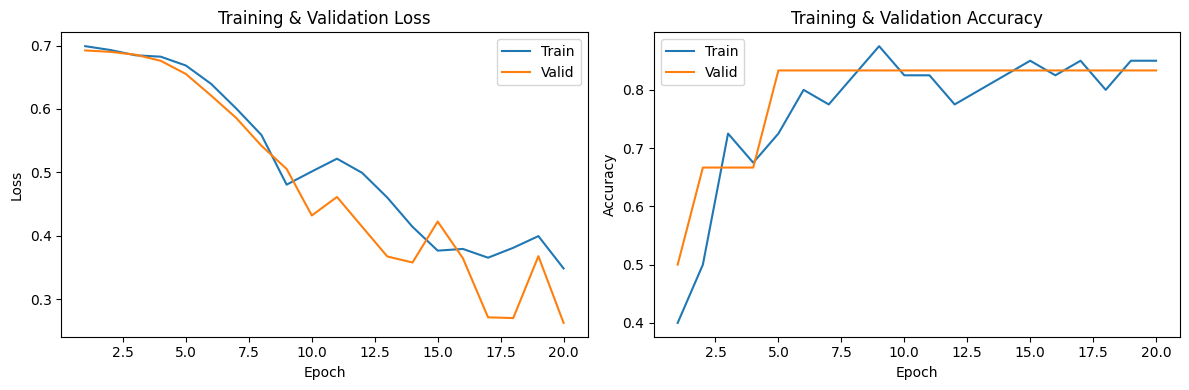

Confusion Matrix (Test):
[[4 0]
 [0 4]]

Classification Report (Test):
              precision    recall  f1-score   support

 no_logo (0)       1.00      1.00      1.00         4
    logo (1)       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

Modell gespeichert unter: /content/drive/MyDrive/Colab Notebooks/Group_28_CNN_FullModel.ph


In [55]:
# Training Loop
history = {
    "train_loss": [],
    "valid_loss": [],
    "train_acc": [],
    "valid_acc": []
}

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = run_epoch(model, train_loader, optimizer, criterion, device, train=True)
    valid_loss, valid_acc = run_epoch(model, valid_loader, optimizer, criterion, device, train=False)

    history["train_loss"].append(train_loss)
    history["valid_loss"].append(valid_loss)
    history["train_acc"].append(train_acc)
    history["valid_acc"].append(valid_acc)

    print(f"Epoch [{epoch}/{NUM_EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"|| Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}")

# Plot: Loss & Accuracy
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train")
plt.plot(epochs, history["valid_loss"], label="Valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train")
plt.plot(epochs, history["valid_acc"], label="Valid")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation auf Test-Set
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

test_cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix (Test):")
print(test_cm)

print("\nClassification Report (Test):")
print(classification_report(all_labels, all_preds, target_names=["no_logo (0)", "logo (1)"]))

# Safe model
torch.save(model, MODEL_SAVE_PATH)
print(f"Modell gespeichert unter: {MODEL_SAVE_PATH}")


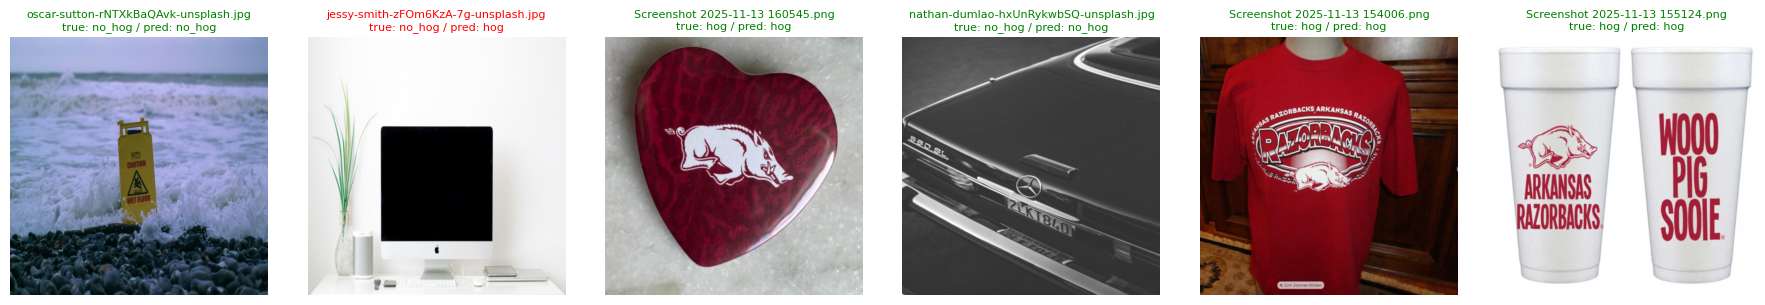

------------------------------------
Accuracy auf den 8 angezeigten Testbildern: 100.00%


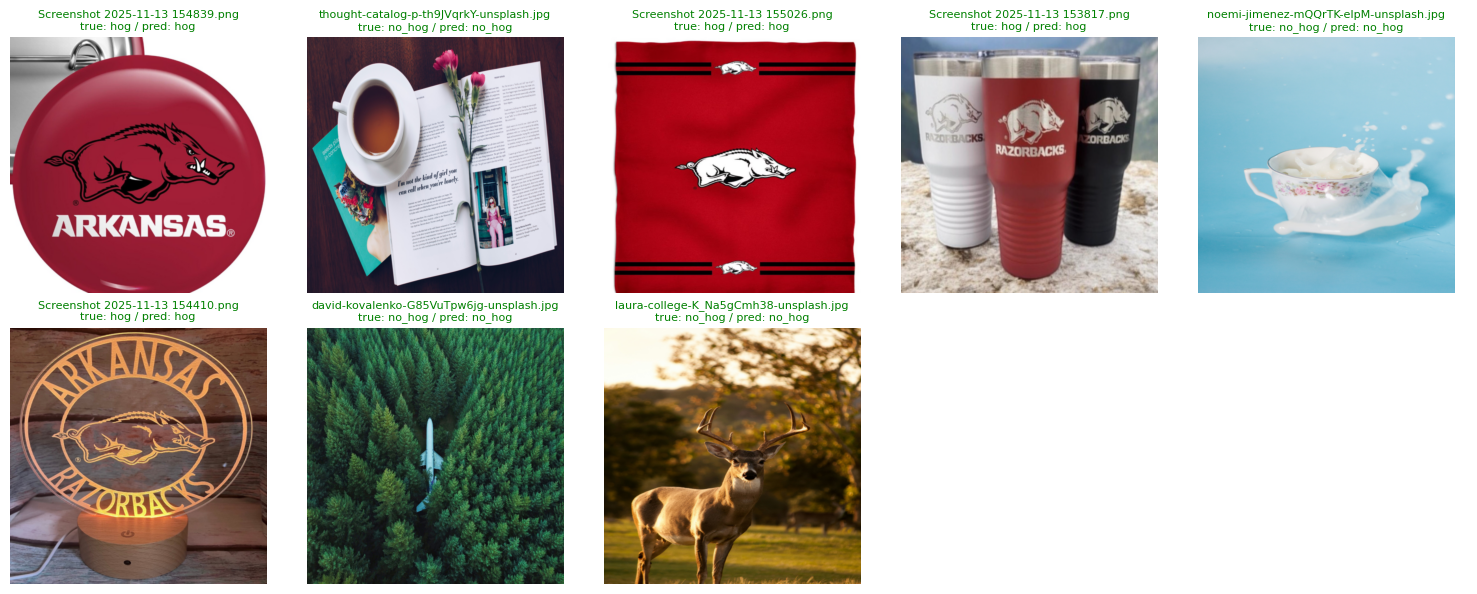

In [56]:
import math
import matplotlib.pyplot as plt

# 0 = no_hogs_random, 1 = hogs
class_names = ["no_hog", "hog"]

# Visual output for validaetion and for testing
def show_validation_predictions(model, max_images=40, n_cols=5):
    model.eval()

    images = []
    true_labels = []
    pred_labels = []
    filenames = []

    with torch.no_grad():
        for idx in valid_indices:  # from your split block
            # get transformed image + mapped label (0/1) from full_dataset
            img, y_true = full_dataset[idx]

            # get original path from base_dataset
            path, _ = base_dataset.samples[idx]
            fname = os.path.basename(path)

            # move image to device, add batch dimension
            logits = model(img.unsqueeze(0).to(device))
            y_pred = logits.argmax(dim=1).item()

            images.append(img)
            true_labels.append(y_true)
            pred_labels.append(y_pred)
            filenames.append(fname)

            if len(images) >= max_images:
                break

    num_images = len(images)
    n_rows = math.ceil(num_images / n_cols)

    plt.figure(figsize=(3 * n_cols, 3 * n_rows))

    for i, (img, y_t, y_p, fname) in enumerate(zip(images, true_labels, pred_labels, filenames)):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        # C,H,W -> H,W,C
        ax.imshow(img.permute(1, 2, 0))
        ax.axis("off")

        color = "green" if y_t == y_p else "red"
        ax.set_title(
            f"{fname}\ntrue: {class_names[y_t]} / pred: {class_names[y_p]}",
            color=color,
            fontsize=8
        )

    plt.tight_layout()
    plt.show()

def show_test_predictions(model, max_images=40, n_cols=5):
    model.eval()

    images = []
    true_labels = []
    pred_labels = []
    filenames = []

    with torch.no_grad():
        # wir laufen über die Indizes des Test-Splits
        for idx in test_indices:
            # Bild + binäres Label (0/1) aus dem Wrapper-Dataset
            img, y_true = full_dataset[idx]

            # Original-Dateiname aus dem ImageFolder
            path, _ = base_dataset.samples[idx]
            fname = os.path.basename(path)

            # Vorhersage berechnen
            logits = model(img.unsqueeze(0).to(device))
            y_pred = logits.argmax(dim=1).item()

            images.append(img)
            true_labels.append(y_true)
            pred_labels.append(y_pred)
            filenames.append(fname)

            if len(images) >= max_images:
                break

    if len(images) == 0:
        print("Keine Testbilder gefunden.")
        return

    # Accuracy
    correct = sum(int(t == p) for t, p in zip(true_labels, pred_labels))
    acc = correct / len(true_labels)
    print(f"Accuracy auf den {len(true_labels)} angezeigten Testbildern: {acc*100:.2f}%")

    # Plot-Grid prepare
    n_images = len(images)
    n_cols = min(n_cols, n_images)
    n_rows = math.ceil(n_images / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

    # axes in 2D-Array
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = np.array([axes])
    elif n_cols == 1:
        axes = np.array([[ax] for ax in axes])

    for i, ax in enumerate(axes.flat):
        if i >= n_images:
            ax.axis("off")
            continue

        img = images[i]
        y_t = true_labels[i]
        y_p = pred_labels[i]
        fname = filenames[i]

        # Tensor (C,H,W) -> (H,W,C)
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        ax.axis("off")

        color = "green" if y_t == y_p else "red"
        ax.set_title(
            f"{fname}\ntrue: {class_names[y_t]} / pred: {class_names[y_p]}",
            color=color,
            fontsize=8
        )

    plt.tight_layout()
    plt.show()


# Methode calls
show_validation_predictions(model, max_images=len(valid_indices), n_cols=6)
print("------------------------------------")
show_test_predictions(model, max_images=40, n_cols=5)

